In [1]:
# Create folder named experiment#1 in processed data, outputs and analysis

# Get data for flow, tessellations, demographics and geographical boundary of WA

# Split data into training and test - create four files: Flows for train and test, region indices for train and test
# Save these files in processed data folder 
# TODO Create visualization and save to outputs of experiement

# Biased sampling on the training data to create two biased datasets - save in processed data folder for experiment1 

# Run single constrained gravity model on biased training data and original data to create three models 
# Run trained models on unbiased test data and create generated flows in outputs 

# Use generated flows from outputs and test true labels from processed data to create fairness metrics and visualizations
# Save this in outputs - fairness.json and fairness.png (for each model)

In [1]:
import sys
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

experiment_id = '1'

In [2]:
# Split the data into train and test sets

sys.path.append(os.path.abspath('../preprocessing'))
from train_test_processing import *
sys.path.append(os.path.abspath('../preprocessing'))
from train_test_split_vis import *

washington = load_state_or_county_data('../data/WA/boundary.geojson')
flow_df = pd.read_csv('../data/WA/flow.csv')
features_df = pd.read_csv('../data/WA/features.csv')
tessellation_df = load_state_or_county_data('../data/WA/tessellation_wpop.geojson')
grid = create_grid(washington.unary_union, 25)

train_output, test_output = flow_train_test_split(tessellation_df, features_df, grid, experiment_id = experiment_id)

# TODO:
# plot_grid_and_census_tracts(grid, tessellation_df, train_output, test_output)

filter_train_test_data(flow_df, tessellation_df, features_df, train_output, test_output, experiment_id = experiment_id)

/Users/apple/opt/anaconda3/envs/pycharm_crowdflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3550: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Processed and saved all datasets successfully.
Missing geoids tessellation have been saved to ../processed_data/1/diagnosis_split_missing/missing_geoids_tessellation.csv.


/Users/apple/opt/anaconda3/envs/pycharm_crowdflow/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/apple/opt/anaconda3/envs/pycharm_crowdflow/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [3]:
# Biased sampling train flow data

sys.path.append(os.path.abspath('../preprocessing'))
from biased_sampling import *

features_df = pd.read_csv('../processed_data/1/train/train_features.csv')
train_flows_df = pd.read_csv('../processed_data/1/train/flows/train_flow.csv')
demographics_df = pd.read_csv('../data/WA/demographics.csv')


calculate_biased_flow(features_df, demographics_df, train_flows_df, demographic_column_name='svi', method=1, order='ascending', sampling=False, experiment_id=experiment_id, bias_factor=0.5)
calculate_biased_flow(features_df, demographics_df, train_flows_df, demographic_column_name='svi', method=1, order='descending', sampling=False, experiment_id=experiment_id, bias_factor=0.5)
calculate_biased_flow(features_df, demographics_df, train_flows_df, demographic_column_name='svi', method=2, order='ascending', sampling=False, experiment_id=experiment_id, bias_factor=0.5)
calculate_biased_flow(features_df, demographics_df, train_flows_df, demographic_column_name='svi', method=2, order='descending', sampling=False, experiment_id=experiment_id, bias_factor=0.5)

/Users/apple/Documents/GitHub/DSSG/crowdflow-fairness/preprocessing/biased_sampling.py:32: FutureWarning: Passing 'suffixes' which cause duplicate columns {'geoid_x'} in the result is deprecated and will raise a MergeError in a future version.
  destination_merge = pd.merge(destination_merge, features_df[['geoid', 'total_population']], how='left', left_on='destination', right_on='geoid')


Missing train sampling flow diagnostic saved to ../processed_data/1/train/diagnosis_sampling_missing/missing_flow.csv.
(17735, 7)
Saved adjusted flows to ../processed_data/1/train/flows/svi/1_ascending_biased_flow.csv.
Missing train sampling flow diagnostic saved to ../processed_data/1/train/diagnosis_sampling_missing/missing_flow.csv.
(17735, 7)


/Users/apple/Documents/GitHub/DSSG/crowdflow-fairness/preprocessing/biased_sampling.py:32: FutureWarning: Passing 'suffixes' which cause duplicate columns {'geoid_x'} in the result is deprecated and will raise a MergeError in a future version.
  destination_merge = pd.merge(destination_merge, features_df[['geoid', 'total_population']], how='left', left_on='destination', right_on='geoid')


Saved adjusted flows to ../processed_data/1/train/flows/svi/1_descending_biased_flow.csv.
Missing train sampling flow diagnostic saved to ../processed_data/1/train/diagnosis_sampling_missing/missing_flow.csv.
(17735, 7)


/Users/apple/Documents/GitHub/DSSG/crowdflow-fairness/preprocessing/biased_sampling.py:32: FutureWarning: Passing 'suffixes' which cause duplicate columns {'geoid_x'} in the result is deprecated and will raise a MergeError in a future version.
  destination_merge = pd.merge(destination_merge, features_df[['geoid', 'total_population']], how='left', left_on='destination', right_on='geoid')


Saved adjusted flows to ../processed_data/1/train/flows/svi/2_ascending_biased_flow.csv.
Missing train sampling flow diagnostic saved to ../processed_data/1/train/diagnosis_sampling_missing/missing_flow.csv.
(17735, 7)


/Users/apple/Documents/GitHub/DSSG/crowdflow-fairness/preprocessing/biased_sampling.py:32: FutureWarning: Passing 'suffixes' which cause duplicate columns {'geoid_x'} in the result is deprecated and will raise a MergeError in a future version.
  destination_merge = pd.merge(destination_merge, features_df[['geoid', 'total_population']], how='left', left_on='destination', right_on='geoid')


Saved adjusted flows to ../processed_data/1/train/flows/svi/2_descending_biased_flow.csv.


In [4]:
# Fit gravity model

sys.path.append(os.path.abspath('../models'))
from gravity import *

tessellation_train = gpd.read_file('../processed_data/1/train/train_tessellation.geojson')
tessellation_test = gpd.read_file('../processed_data/1/test/test_tessellation.geojson')

gravity_0 = grav_Model(tessellation_train, tessellation_test, '../processed_data/1/train/flows/train_flow.csv', '../processed_data/1/test/flows/test_flow.csv', 'gravity_singly_constrained', 'flows')

Model fitting starts...
Model fitting completed.


100%|██████████| 628/628 [00:00<00:00, 2384.43it/s]
/Users/apple/opt/anaconda3/envs/pycharm_crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)
/Users/apple/opt/anaconda3/envs/pycharm_crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:298: RuntimeWarning: invalid value encountered in multiply
  trip_probs_matrix = trip_probs_matrix * relevances_dest ** self.destination_exp * \
/Users/apple/opt/anaconda3/envs/pycharm_crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:378: RuntimeWarning: invalid value encountered in divide
  trip_probs_matrix = (trip_probs_matrix.T / np.sum(trip_probs_matrix, axis=1)).T


In [5]:
# TODO:
gravity_1 = grav_Model(tessellation_train, tessellation_test, '../processed_data/1/train/flows/svi/1_ascending_biased_flow.csv', '../processed_data/1/test/flows/test_flow.csv', 'gravity_singly_constrained', 'flows')

Model fitting starts...
Model fitting completed.


100%|██████████| 628/628 [00:00<00:00, 2286.22it/s]
/Users/apple/opt/anaconda3/envs/pycharm_crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)
/Users/apple/opt/anaconda3/envs/pycharm_crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:298: RuntimeWarning: invalid value encountered in multiply
  trip_probs_matrix = trip_probs_matrix * relevances_dest ** self.destination_exp * \
/Users/apple/opt/anaconda3/envs/pycharm_crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:378: RuntimeWarning: invalid value encountered in divide
  trip_probs_matrix = (trip_probs_matrix.T / np.sum(trip_probs_matrix, axis=1)).T


In [ ]:
gravity_2 = grav_Model(tessellation_train, tessellation_test, '../processed_data/1/train/flows/svi/1_descending_biased_flow.csv', '../processed_data/1/test/flows/test_flow.csv', 'gravity_singly_constrained', 'flows')

In [ ]:
gravity_3 = grav_Model(tessellation_train, tessellation_test, '../processed_data/1/train/flows/svi/2_ascending_biased_flow.csv', '../processed_data/1/test/flows/test_flow.csv', 'gravity_singly_constrained', 'flows')

In [ ]:
gravity_4 = grav_Model(tessellation_train, tessellation_test, '../processed_data/1/train/flows/svi/2_descending_biased_flow.csv', '../processed_data/1/test/flows/test_flow.csv', 'gravity_singly_constrained', 'flows')

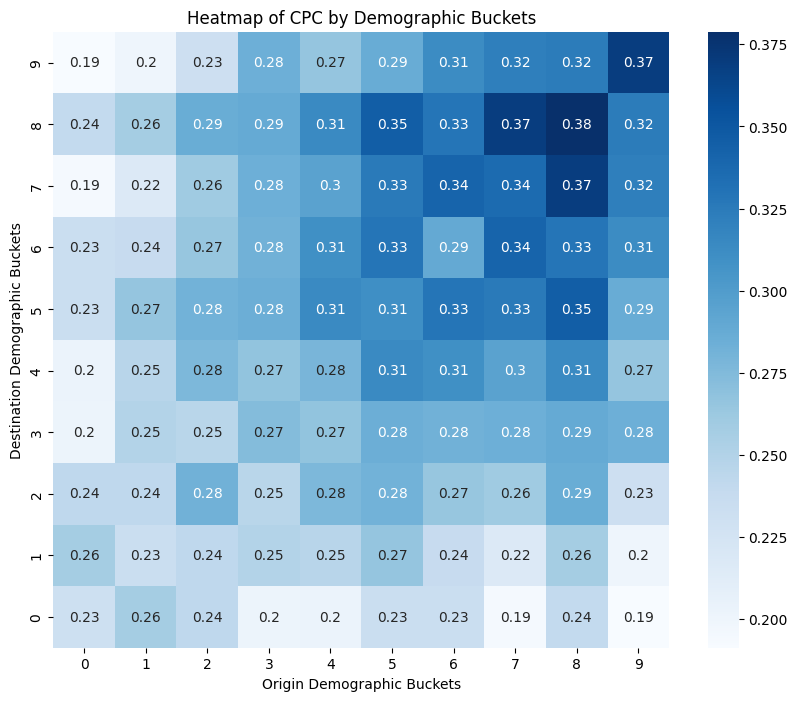

Fairness Metric (kl_divergence of CPC): 0.013373327589887574
Overall CPC: 0.28630827789651914


In [1]:
import sys
import os
sys.path.append(os.path.abspath('../evaluation'))
from eval import FlowEvaluator

flows_path = '../processed_data/1/test/flows/test_flow.csv'
generated_flows_path = '../outputs/1/synthetic_data_gravity_singly_constrained/train_flow.csv' # TODO change accordingly
demographics_path = '../data/WA/demographics.csv'
demographic_column = 'svi'
evaluator = FlowEvaluator(flows_path, generated_flows_path, demographics_path)
fairness = evaluator.evaluate_fairness(accuracy_metric='CPC', variance_metric='kl_divergence', demographic_column=demographic_column)